# Определение стабильной части средств банка на 2 месяца вперед 

In [ ]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Исследование имеющихся данных

In [ ]:
# открываем данные
df = pd.read_csv("/content/ВС DS Сбер data.csv", 
                 index_col=[0], parse_dates=[0], dayfirst=True, keep_default_na=False, sep=';')

In [ ]:
print(f'Данные содержат информацию за период с {df.index.min()} по {df.index.max()}')

Данные содержат информацию за период с 2013-12-30 00:00:00 по 2019-10-10 00:00:00


Проверим, в хронологическом ли порядке расположены даты и время:

In [ ]:
print(df.index.is_monotonic)

True


Посмотрим наличие пропусков:

In [ ]:
df.isna().sum()

VALUE    0
dtype: int64

Посмотрим на график имеющегося временного ряда

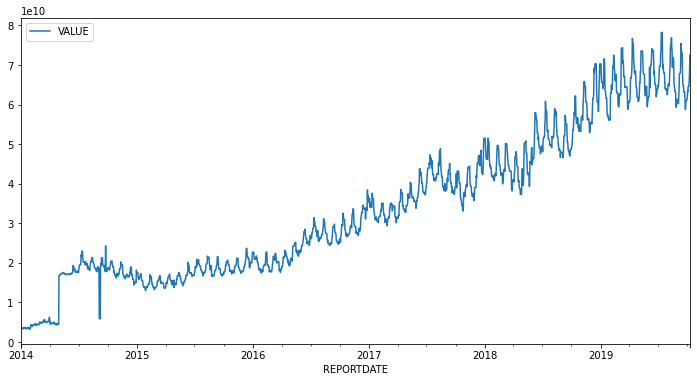

In [ ]:
df.plot(figsize=(12,6))

График ярко выраженных выбросов не имеет, при этом имеет ярко выраженный тренд. Из это можно сделать вывод о том, что ряд не является стационарным.

Посмотрим дополнительно на график boxplot на наличие выбросов.

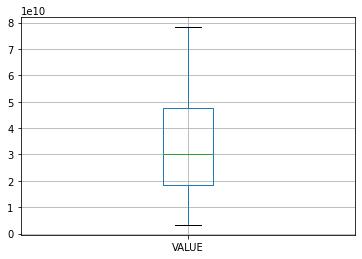

In [ ]:
df.boxplot(column=['VALUE'])

**Итог**

1. Имеем временной ряд с хронологически расположенной информацией о стабильной части средств за период с 2013-12-30 по 2019-10-10.

2. Пропуски и выбросы отсутствуют.

3. Ряд имеет ярко выраженный тренд, что говорит о его нестационарности (к этому вернемся ниже).

## Подготовка к обучению и обучение модели

In [ ]:
# делим данные на обучающую и тестовую выборки
df_train, df_test = \
              np.split(df, [int(.8*len(df))])

In [ ]:
# сохраняем тестовые значения
y_test = df_test['VALUE']

In [ ]:
# функция для отрисовки графиков
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
         y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.952295


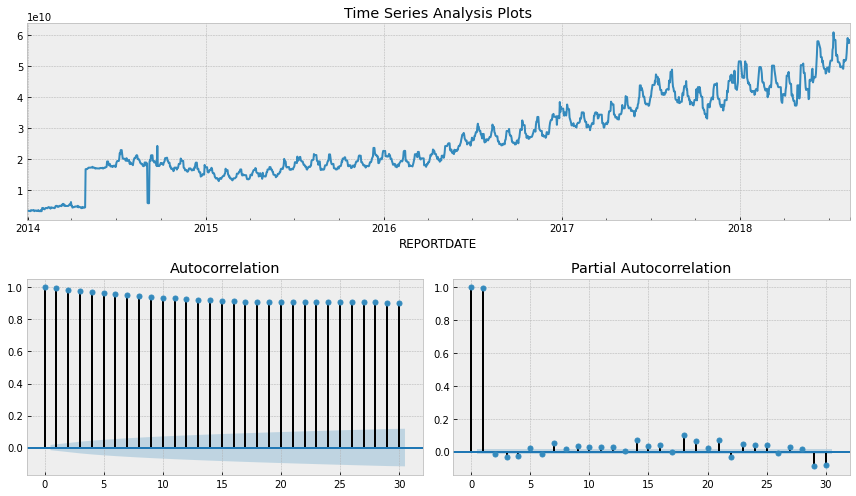

In [ ]:
tsplot(df_train.VALUE, lags=30)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

Критерий Дики-Фуллера: p=0.698166
Оптимальный параметр преобразования Бокса-Кокса: 0.647583


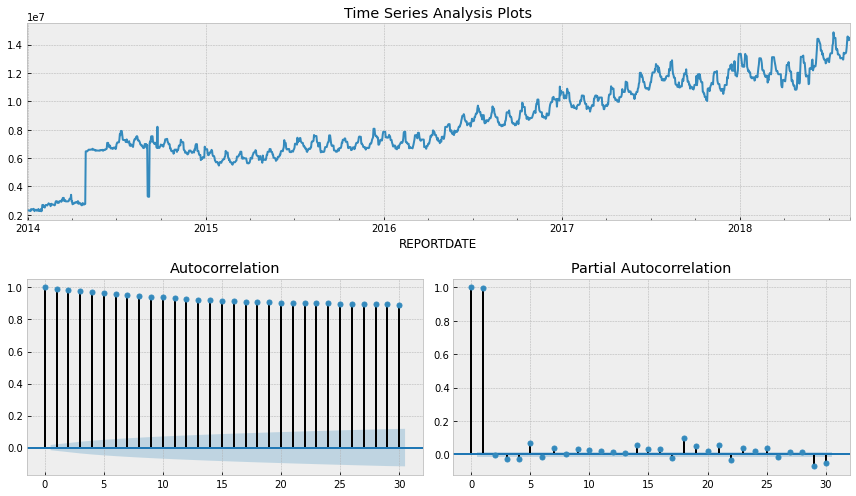

In [ ]:
def invboxcox(y, lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = df_train.copy()
data['Value_box'], lmbda = scs.boxcox(df_train.VALUE)   
tsplot(data.Value_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. 

Критерий Дики-Фуллера: p=0.000000


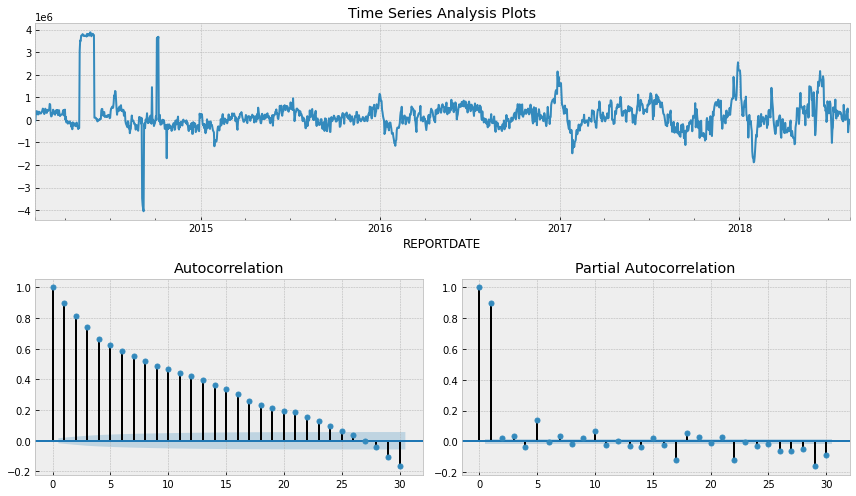

In [ ]:
data['Value_box_season'] = data.Value_box - data.Value_box.shift(30)
tsplot(data.Value_box_season[30:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.000000


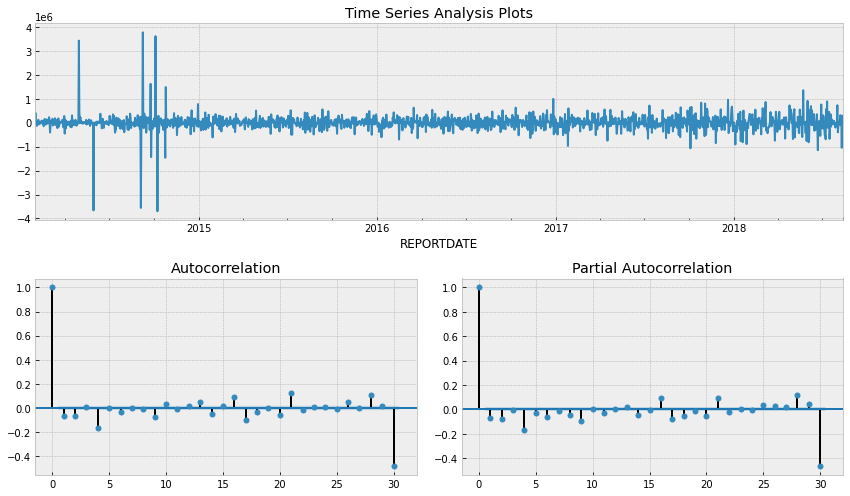

In [ ]:
data['Value_box_season_diff'] = data.Value_box_season - data.Value_box_season.shift(1)
tsplot(data.Value_box_season_diff[30+1:], lags=30)

Получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции. Найдем параметры для SARIMA модели.

In [ ]:
# код закомментирован для экономия времени, далее воспользуемся уже подобранными параметрами
'''warnings.filterwarnings("ignore") 
p = d = q = range(0, 10)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
best_pdq = (0, 0, 0)
best_param_seasonal = (0, 0, 0, 0)
best_aic = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data.Value_box,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_pdq = param
                best_param_seasonal = param_seasonal
                best_aic = results.aic

        except:
            continue
print('ARIMA{}x{}12 - AIC:{}'.format(best_pdq, best_param_seasonal, best_aic))'''

'warnings.filterwarnings("ignore") \np = d = q = range(0, 10)\npdq = list(itertools.product(p, d, q))\nseasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]\nbest_pdq = (0, 0, 0)\nbest_param_seasonal = (0, 0, 0, 0)\nbest_aic = np.inf\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(data.Value_box,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n            results = mod.fit()\n            #print(\'ARIMA{}x{}12 - AIC:{}\'.format(param, param_seasonal, results.aic))\n            if results.aic < best_aic:\n                best_pdq = param\n                best_param_seasonal = param_seasonal\n                best_aic = results.aic\n\n        except:\n           

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Value_box, order=(8, 1, 2), 
                                        seasonal_order=(2, 1, 2, 30)).fit(disp=-1)
#print(best_model.summary())  

CPU times: user 9min 35s, sys: 3min 2s, total: 12min 38s
Wall time: 6min 48s


Проверим остатки модели:

Критерий Дики-Фуллера: p=0.000000


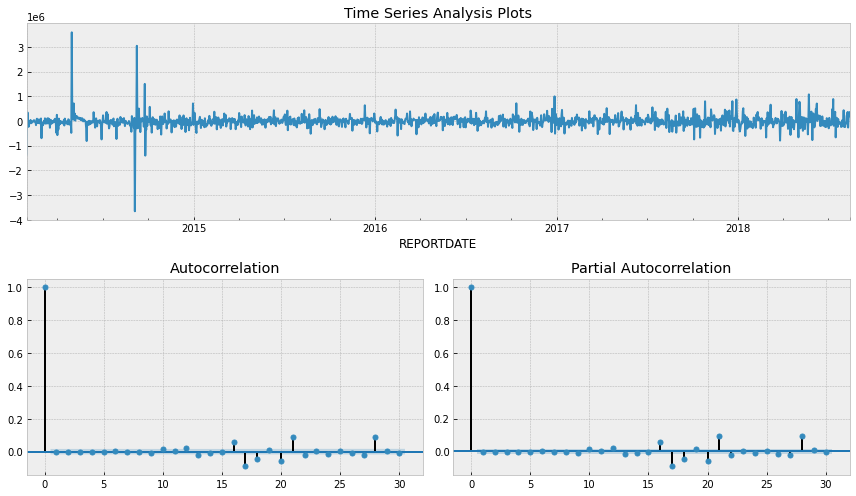

In [ ]:
tsplot(best_model.resid[30:], lags=30)

Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

## Прогноз тестовой части выборки

In [ ]:
# построение прогноза
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = df_test.index[0], end = df_test.index[-1]), lmbda)

In [ ]:
# перевод прогнозных значений в датафрейм
forecast = pd.DataFrame(forecast).reset_index()
forecast.columns=['REPORTDATE', 'value_pred']
forecast['value_pred'] = forecast['value_pred'].astype('int64')

In [ ]:
# перевод тестовых значений в датафрейм
y_test = pd.DataFrame(y_test).reset_index()
y_test.columns=['REPORTDATE', 'actual']

In [ ]:
# объединение в один датафрейм тестовых и прогнозных значений
df_pred = y_test.merge(forecast)
df_pred = df_pred.set_index('REPORTDATE')
df_pred.head()

,actual,value_pred
REPORTDATE,,
2018-08-14,56752531677,57347352256
2018-08-15,54374083157,56309277591
2018-08-16,53051592781,55719809712
2018-08-17,51971316206,54998842442
2018-08-18,51971316206,54514485305


Для наглядности оценки точности прогноза мы возьмем среднюю абсолютную процентную ошибку (MAPE – Mean Absolute Percent Error):

In [ ]:
mape = np.mean(np.abs((np.array(y_test['actual']) - np.array(df_pred.value_pred))/np.array(y_test['actual'])))*100
mape

9.30965800358415

Посмотрим соответствие прогноза реальным значениям на графике

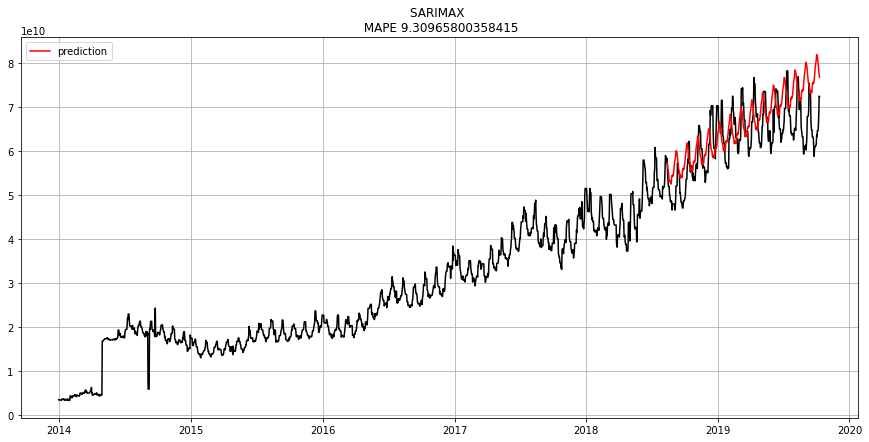

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df, "black")
plt.plot(df_pred.value_pred, "r", label="prediction")
plt.legend(loc="best")
plt.title("SARIMAX \n MAPE {}".format(mape))
plt.grid(True);

## Построение прогноза на 2 месяца вперед

In [ ]:
# строим предсказания
forecast_future = invboxcox(best_model.predict(start = df_test.index[-1], end = '2019-12-10'), lmbda)

In [ ]:
# переводим предсказания в датафрейм
df_future = pd.DataFrame(forecast_future).reset_index()
df_future.columns=['REPORTDATE', 'value_future']
df_grafic = df_future.copy()

In [ ]:
# посчитаем стандартное отклонение и доверительный 95% интервал
df_future['std'] = df_future['value_future'].rolling(5).std()
upper = df_future['value_future'].rolling(5).mean() + 1.96 * df_future['std']
lower = df_future['value_future'].rolling(5).mean() - 1.96 * df_future['std']

In [ ]:
# посчитаем аномальные значения
Anomalies = np.array([np.NaN]*len(df_future['value_future']))
df_future['Anomalies'] = Anomalies
Anomalies_lower = df_future.value_future[df_future.value_future<lower]
Anomalies_upper = df_future.value_future[df_future.value_future>upper]

In [ ]:
df_future = pd.concat([df_future, pd.DataFrame(upper), pd.DataFrame(lower), pd.DataFrame(Anomalies_upper), pd.DataFrame(Anomalies_lower)], axis=1)
df_future = df_future.set_index('REPORTDATE')
df_future.columns=['value_future', 'std', 'anomalies', 'upper', 'lower', 'anomalies_upper', 'anomalies_lower']

In [ ]:
# выведем значения предсказаний на 2 месяца
df_future

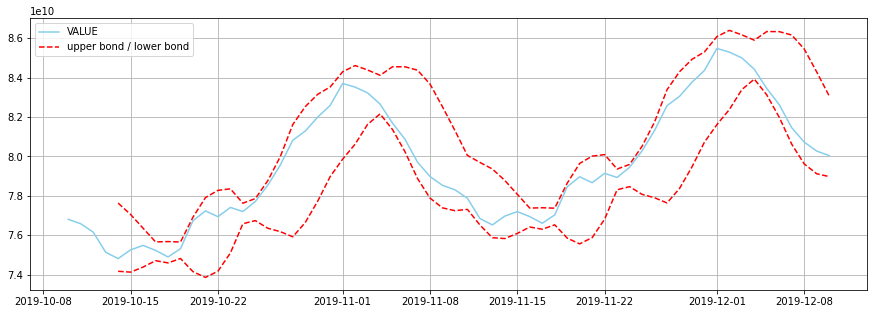

In [ ]:
# построим график, на котором отразим полученные значения, доверительный 95% интервал
plt.figure(figsize=(15, 5))
plt.plot(df_future['value_future'], label="VALUE", color='skyblue')
#plt.plot(df_future['std'], label="std", color='yellow')
plt.plot(df_future.lower, "r--", label="upper bond / lower bond")
plt.plot(df_future.upper, "r--")
plt.plot(df_future.anomalies_upper, "bo", markersize=6)
plt.plot(df_future.anomalies_lower, "bo", markersize=6)
plt.grid(True)
plt.legend();

**Вывод**

Имеющийся нестационарный ряд был преобразован в стационарный и использована для прогнозирования модель SARIMAX. Модель показала среднюю абсолютную процентную ошибку - 9,3. Рассчитан прогноз стабильной части средств банка на ближайшие 2 месяца, посчитан 95% доверительный интервал. Полученные значения входят в доверительный интервал, аномальных значений нет.

*Что можно улучшить: в рамках данного исследования использовали получившуюся на трейновой выборке модель. Для более точного прогноза на будущий период времени можно переобучить модель на всем временном ряду.*